# Simulation of Ising models on multiple devices

In this notebook, we investigate the simulation of Ising model using SimuQ. 

## Ising model

An Ising model is a statistical model to study the magnetism of materials. 

<div> <img src="imgs/ising.png" width="300"/> </div> 

It contains $N$ qubit sites forming a lattice represented by a graph $G=(V, E)$. The Hamiltonian in our consideration is $$H=\sum_{(j, k)\in E}J_{jk} Z_jZ_k+\sum_{j=1}^{N} h_jX_j.$$ Here $J_{jk}Z_jZ_k$ represents the interaction between sites $j$ and $k$ and $J_{jk}$ is the interaction strength. For $J_{jk}>0$, it represents ferromagnetic material, and $J_{jk}<0 $ represents anti-ferromagnetic material. We also consider an external magnetic field acting $h_j X_j$ on site $j$ in an orthogonal direction. 

We program the Ising model in SimuQ with Hamiltonian Modeling Language.

We consider two types of Ising models in this notebook, with chain or cycle topologies, and let $N=6$ and $T=1$.

For simplicity, we set the interaction strength and external field strength to be $1$.

We can classically simulate the evolution of Ising models via SimuQ's QuTiP backend, which translates the above systems and simulate them by QuTiP. To do so, we declare a QuTiP provider first.

We first simulate ``Ising_cycle``. The following command asks the QuTiP provider to translate the system into QuTiP and store the results internally.

Compiled.


Then we execute the simulation and retrieve the results as the ground truth data. The results are stored in a dictionary. To extract the probability of obtaining the ground state, we access the dictionary with key ``'000000'``.

Solved.


0.30216309739832453


We do the same for ``Ising_chain``.

In the following, we will use total variational distance to evaluate the simulation results, defined for two distribution $P_1, P_2$ as $$TV(P_1, P_2)=\frac{1}{2}\sum_x |P_1[x]-P_2[x]|.$$ We realize it as a function:

In [9]:
def TV(P1, P2):
    keys = set(P1.keys()).union(P2.keys())
    s = 0
    for k in keys :
        if k not in P1.keys():
            s += P2[k]
        elif k not in P2.keys():
            s += P1[k]
        else :
            s += abs(P1[k] - P2[k])
    return s / 2

## Deploy on multiple platforms

**CAVEAT: quantum computers are expensive, quera/ionq through braket is $(0.3+0.01*shots)）**

### QuEra's Neutral Atom Arrays

We can access QuEra's devices via Amazon Braket. To install and configure Amazon Braket, please refer to [SimuQ README](https://github.com/PicksPeng/SimuQ/blob/main/README.md).

We first create a Braket provider to manage the interactions with SimuQ compiler. 

In [9]:
from simuq.braket import BraketProvider

bp = BraketProvider()

You can check the supported devices and corresponding AAIS in the Braket provider. 

In [10]:
bp.supported_backends()

Hardware provider: ionq  -  Device name: harmony  -  AAIS supports: ['heis_aais']
Hardware provider: ionq  -  Device name: aria-1  -  AAIS supports: ['heis_aais']
Hardware provider: quera  -  Device name: Aquila  -  AAIS supports: ['rydberg1d_global', 'rydberg2d_global']


Here we will use QuEra's device named Aquila, with the 2D Rydberg AAIS with global laser control. To compile ``Ising_cycle`` to it, we execute

In [11]:
bp.compile(Ising_cycle, provider="quera", device="Aquila", aais="rydberg2d_global", tol=1)

We can visualize the compilation results that configure QuEra devices by executing

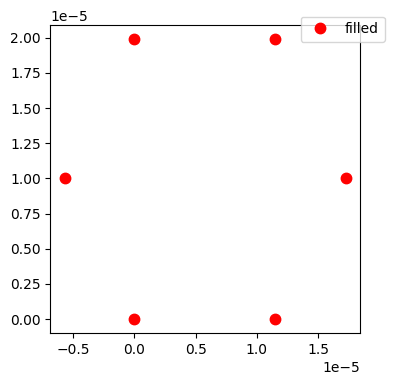

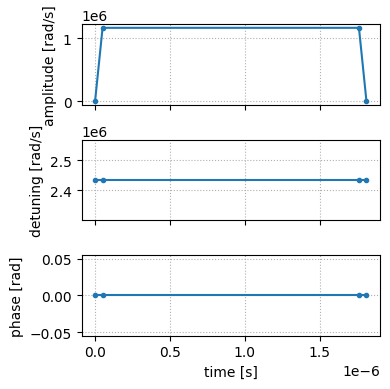

In [12]:
bp.visualize()

The compilation results can be directly sent to devices to execute. Before we submit them, we use Amazon Braket's simulator to simulate the evolution first.

In [11]:
bp.run(on_simulator=True)

Submitted.


Then we can retrieve the results similarly. We examine the probability of obtaining the ground state again to compare with ideal classical simulation results.

In [16]:
res_quera = bp.results()
print(res_quera["000000"])

0.335


The error mainly comes from the non-neighboring interactions between sites. To compare it with the ideal results, we calculate the TV between the two distrubtions

In [19]:
TV(res_cycle_gt, res_quera)

0.10084898882144529

We may send the pulse schedule to QuEra's device to run. The following command submits a job to AWS via Amazon Braket, which returns a task. The task arn is the identifier for you to retrieve results later if the current environment is lost, so please record it carefully. 

In [ ]:
# bp.run(shots=1000)

Typically you may need to wait for several days for the queuing on the cloud. We reuse a former task which submitted the same pulse schedule here for the explanation. We can retrieve the results by a previously recorded task arn.

In [21]:
res_quera_real = bp.results(task_arn="arn:aws:braket:us-east-1:795824654075:quantum-task/acd3ae81-a220-41a7-ac34-d3f6371cb516")
print(res_quera_real["000000"])

0.438


The real device execution is noisy, hence the retrieved results are significantly different than the noiseless simulation results. We can compare them by TV

In [22]:
TV(res_quera, res_quera_real)

0.44150000000000017

We may also calculate the distance between real device execution results and the ground truth results.

In [24]:
TV(res_cycle_gt, res_quera_real)

0.4879475083069719

Now we proceed to the chain Ising model. However, current QuEra devices only support global laser control, while the chain Ising model requires local laser control because of asymmetry of sites. We may try to compile ``Ising_chain`` with the QuEra device by

In [27]:
try:
    bp.compile(Ising_chain, "quera", "Aquila", "rydberg2d_global", tol=1)
except:
    print("Failed.")

Failed.


### IonQ's Trapped Ion Arrays

To access IonQ's devices, you may continue with Braket providers, while send in IonQ's device information and corresponding AAIS when compiling. 

Alternatively, here we access IonQ's devices via IonQ Quantum Cloud. To install, please refer to [SimuQ README](https://github.com/PicksPeng/SimuQ/blob/main/README.md). Similarly, we create an IonQ provider. 

We can follow the same procedures to compile and deploy the Ising models on IonQ's devices. Here we first validate the compilation on the noiseless simulator of IonQ. Similarly, the distance between the noiseless simulation and the ground truth results are calculated by TV.

{'id': 'bab7b604-acd2-4d1c-adb7-d083468d7b64', 'status': 'ready', 'request': 1692158692}


0.271998682


A noisy simulation for IonQ devices is also possible. We repeat the above procedure to see how noises will likely affect the results.

{'id': '838069d5-5375-4091-81a8-8c04bae29639', 'status': 'ready', 'request': 1692174775}


0.17335761663751809

We may then send the compiled circuits to be executed on the real devices. We also use a previously submitted job to present the results.

0.264404296875


The above procedure can also be applied to ``Ising_chain`` since IonQ devices have complete connectivity. 

0.1616826263154284

### IBM's Transmon Systems

Here we access IBM’s devices via qiskit. Similarly, we create an IBMprovider. 

In [11]:
from simuq.ibm import IBMProvider
ibm=IBMProvider(from_file="../../../qiskit_APIKEY", hub="ibm-q-ornl", group="ornl", project="phy147")

We can follow the same procedures to compile and deploy the Ising models on IBM's devices. Here we first validate the compilation on the noiseless simulator from qiskit. Similarly, the distance between the noiseless simulation and the ground truth results are calculated by TV. Notice that simulating pulse level instructions is much more time consuming than simulating circuit level instructions. Therefore, we only simulate gate level instructions here.

In [11]:
ibm.compile(Ising_chain, backend="ibmq_guadalupe", trotter_num=4, use_pulse=False)

In [13]:
ibm.run(on_simulator=True)

In [16]:
res_ibm_chain = ibm.results(on_simulator=True)
TV(res_chain_gt, res_ibm_chain)

0.13625762530607033

A noisy simulation for IBM devices is also possible. We repeat the above procedure to see how noises will likely affect the results.

In [30]:
ibm.run(on_simulator=True, with_noise=True)

In [31]:
res_ibm_chain_noisy = ibm.results(on_simulator=True)
TV(res_chain_gt, res_ibm_chain_noisy)

0.14297352472366937

We may then send the compiled circuits to be executed on the real devices. We also use a previously submitted job to present the results.

In [32]:
# ibm.run(shots=4096)

In [12]:
res_ibm_chain_real = ibm.results(job_id="cjg1s533smr2evmgi8b0")
TV(res_chain_gt, res_ibm_chain_real)

0.36901814080051965

Next, we try to use pulse level compilation to enhance the performance.

In [26]:
ibm.compile(Ising_chain, backend="ibmq_guadalupe", trotter_num=4, use_pulse=True)

In [28]:
# ibm.run(shots=4096)

In [34]:
res_ibm_chain_real = ibm.results(job_id="cjgll3q67vbih38voap0")
TV(res_chain_gt, res_ibm_chain_real)

0.31003438692875523